In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
def read_file(filename):
    with open(filename) as f:
        for line in f:
            yield line.strip().split(' ')

df = pd.read_csv('/Users/shwetatiwari2601/Projects/dt8122/datasets/power.txt', sep='\t', header=None, 
                 names=['df1', 'df2', 'df3', 'df4', 'df5'], index_col=False)  


#df = pd.read_csv('/Users/shwetatiwari2601/Projects/dt8122/datasets/protein.txt', sep=' ', header=None, 
                 #names=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9', 'df10'], index_col=False)
df.head()

,df1,df2,df3,df4,df5
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [3]:
# Input features X
X = df.iloc[:, :4]
#X = df.iloc[:, :9]
# Target y
y = df.iloc[:, 4:]
#y = df.iloc[:, 9:]

In [4]:
# Splitting dataset into train and test set, test size = 10% of the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [5]:
Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))

In [6]:
log2pi = np.log(2.0 * np.pi)
def log_gaussian(x, mu, sigma):
    return float(-0.5 * log2pi - np.log(np.abs(sigma))) - (x - mu)**2 / (2 * sigma**2)

def log_gaussian_logsigma(x, mu, logsigma):
    return float(-0.5 * log2pi) - logsigma - (x - mu)**2 / (2 * torch.exp(logsigma)**2)

In [7]:
class MLPLayer(nn.Module):
    def __init__(self, n_input, n_output, sigma_prior):
        super(MLPLayer, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.sigma_prior = sigma_prior
        self.W_mu = nn.Parameter(torch.Tensor(n_input, n_output).normal_(0, 0.01))
        self.W_logsigma = nn.Parameter(torch.Tensor(n_input, n_output).normal_(0, 0.01))
        self.b_mu = nn.Parameter(torch.Tensor(n_output).uniform_(-0.01, 0.01))
        self.b_logsigma = nn.Parameter(torch.Tensor(n_output).uniform_(-0.01, 0.01))
        self.lpw = 0
        self.lqw = 0
#scale mixture priors and variational posteriors
    def forward(self, X, infer=False):
        if infer:
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_output)
            return output

        epsilon_W, epsilon_b = self.get_random()
        W = self.W_mu + torch.log(1 + torch.exp(self.W_logsigma)) * epsilon_W
        b = self.b_mu + torch.log(1 + torch.exp(self.b_logsigma)) * epsilon_b
        output = torch.mm(X, W) + b.expand(X.size()[0], self.n_output)
        self.lpw = log_gaussian(W, 0, self.sigma_prior).sum() + log_gaussian(b, 0, self.sigma_prior).sum() # 
        self.lqw = log_gaussian_logsigma(W, self.W_mu, self.W_logsigma).sum() + log_gaussian_logsigma(b, self.b_mu, self.b_logsigma).sum()
        return output

    def get_random(self):
        return Variable(torch.Tensor(self.n_input, self.n_output).normal_(0, self.sigma_prior).cpu()), Variable(torch.Tensor(self.n_output).normal_(0, self.sigma_prior).cpu())


In [8]:
class MLP(nn.Module):
    def __init__(self, n_input, sigma_prior):
        super(MLP, self).__init__()
        self.l1 = MLPLayer(n_input, 1024, sigma_prior)
        self.l1_relu = nn.ReLU()
        self.l2 = MLPLayer(1024, 1024, sigma_prior)
        self.l2_relu = nn.ReLU()
        self.l3 = MLPLayer(1024, 1, sigma_prior)

    def forward(self, X, infer=False):
        output = self.l1_relu(self.l1(X, infer))
        output = self.l2_relu(self.l2(output, infer))
        output = self.l3(output, infer)
        return output

    def get_lpw_lqw(self):
        lpw = self.l1.lpw + self.l2.lpw + self.l3.lpw # log priors
        lqw = self.l1.lqw + self.l2.lqw + self.l3.lqw # variational posterior
        return lpw, lqw

In [9]:
def forward_pass_samples(X, y):
    s_log_pw, s_log_qw, s_log_likelihood = 0., 0., 0.
    for _ in range(n_samples):
        output = net(X)
        sample_log_pw, sample_log_qw = net.get_lpw_lqw()
        sample_log_likelihood = log_gaussian(y, output, sigma_prior).sum()
        s_log_pw += sample_log_pw
        s_log_qw += sample_log_qw
        s_log_likelihood += sample_log_likelihood

    return s_log_pw/n_samples, s_log_qw/n_samples, s_log_likelihood/n_samples

# Total loss
def criterion(l_pw, l_qw, l_likelihood):
    return ((1./n_batches) * (l_qw - l_pw) - l_likelihood).sum() / float(batch_size)

In [10]:
y_test.shape

(957, 1)

In [11]:
import time
train_acc = []
test_acc = []
n_input = X_train.shape[1]
M = X_train.shape[0]
sigma_prior = float(np.exp(-3))
n_samples = 3
learning_rate = 0.001
n_epochs = 10

# Initialize network
net = MLP(n_input, sigma_prior)
net = net.cpu()

# building the objective
# evaluating by samples
log_pw, log_qw, log_likelihood = 0., 0., 0.
batch_size = 100
n_batches = M / float(batch_size)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

n_train_batches = int(X_train.shape[0] / float(batch_size))

start_time = time.time()

for e in range(n_epochs):
    errs = []
    for b in range(n_train_batches):
        net.zero_grad()
        X = Var(X_train.values)
        y = Var(y_train.values)

        log_pw, log_qw, log_likelihood = forward_pass_samples(X, y)
        loss = criterion(log_pw, log_qw, log_likelihood)
        errs.append(loss.data.cpu().numpy())
        loss.backward()
        optimizer.step()

    X = Var(X_test.values)
    pred = net(X, infer=False)
    _, out = torch.max(pred, 1)
    
    print('Epoch', e, '|', 'Epoch_loss', np.mean(errs))
running_time = time.time() - start_time
print('Running time in seconds:', running_time)


Epoch 0 | Epoch_loss 322607420.0
Epoch 1 | Epoch_loss 54592876.0
Epoch 2 | Epoch_loss 62713770.0
Epoch 3 | Epoch_loss 64466150.0
Epoch 4 | Epoch_loss 54482468.0
Epoch 5 | Epoch_loss 68626510.0
Epoch 6 | Epoch_loss 49440160.0
Epoch 7 | Epoch_loss 59290410.0
Epoch 8 | Epoch_loss 56123864.0
Epoch 9 | Epoch_loss 55993330.0
Running time in seconds: 1493.8956809043884


In [12]:
#torch.save(model_, '/Users/shwetatiwari2601/Projects/dt8122/results/protein_BBB_'+str(i)+'.pth')
print(len(y_test.values), len(pred))

957 957


In [13]:
print(type(pred))
y_pred = (Variable(pred).data).cpu().numpy()
print(type(y_pred))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


In [14]:
import pickle
with open('/Users/shwetatiwari2601/Projects/dt8122/results/y_pred_BBB_power.pkl', 'wb') as file:
    pickle.dump(y_pred, file)

In [15]:
RMSE = np.sqrt(np.mean((y_pred - y_test.values)**2))
RMSE

31.280447

In [16]:
import scipy
def pred_interval(y_true, y_pred, quantile):  # z = significance level of 95%, which is the Gaussian critical value of 1.96.
    z = scipy.stats.norm.ppf(quantile)
    sum_err = np.sum((y_true - y_pred) ** 2)
    stdev = np.sqrt(1/(len(y_true) - 2) * sum_err)
    interval = z * stdev
    return interval

In [17]:
interval = pred_interval(y_test.values, y_pred, .95)
lower = y_pred - interval
upper = y_pred + interval
interval

51.50560303433042

In [18]:
print(upper[1], y_pred[1], lower[1])

[467.62607] [416.12045] [364.61484]


In [19]:
results = pd.DataFrame(index=y_test.index)
results['y_true'] = y_test.values
results['y_pred'] = y_pred
results['y_lower'] = lower
results['y_upper'] = upper
results = results.reset_index(drop=True)
results.head()

,y_true,y_pred,y_lower,y_upper
0,438.390015,416.412506,364.906891,467.918121
1,446.920013,416.120453,364.614838,467.626068
2,492.089996,439.773193,388.267578,491.278809
3,456.200012,430.888947,379.383331,482.394562
4,446.940002,422.476593,370.970978,473.982208


In [20]:
print(y_pred.max(), y_pred.min(), y_test.values.max(), y_test.values.min())

447.5086 400.58978 494.91 425.12


In [21]:
def picp(y_true, y_lower, y_upper):
    x = []
    for y, lo, up in zip(y_true, y_lower, y_upper):
        condition = ((lo < y) & (y < up))
        if condition:
            value = 1
        else:
            value = 0
        x.append(value)
    result = np.sum(x) / float(len(x))
    return result

In [22]:
def mpiw(y_lower, y_upper):
    result = (y_upper - y_lower).mean()
    return result

In [23]:
RMSE = np.sqrt(np.mean((y_pred - y_test.values)**2))

In [24]:
PICP = picp(y_test.values, lower, upper)
MPIW = mpiw(lower, upper)
RMSE = np.sqrt(np.mean((y_pred - y_test.values)**2))
print('RMSE = ', RMSE)
print('PICP = ', PICP)
print('MIPW = ', MPIW)

RMSE =  31.280447
PICP =  0.9926854754440961
MIPW =  103.01123


In [31]:
import matplotlib.pyplot as plt
def plot_prediction_intervals(data, y_true_label='y_true',  y_pred_label='y_pred', 
                              y_lower_label='y_lower', y_upper_label='y_upper',
                              figsize=(20,5)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(data[[y_true_label]], color='green', linestyle='solid')
    ax.plot(data[[y_pred_label]], color='blue', linestyle='dotted')
    ax.fill_between(data.index, data[y_lower_label], data[y_upper_label], 
                    label='prediction interval', color='grey')

#     ax.set_xlim([0, len(data) -1 ])

    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('Predictions generated by BayesByBackprop')
    ax.legend(['Ground Truth', 'Point Prediction', 'Prediction Interval'], loc=2)
	
    plt.close()
    return fig

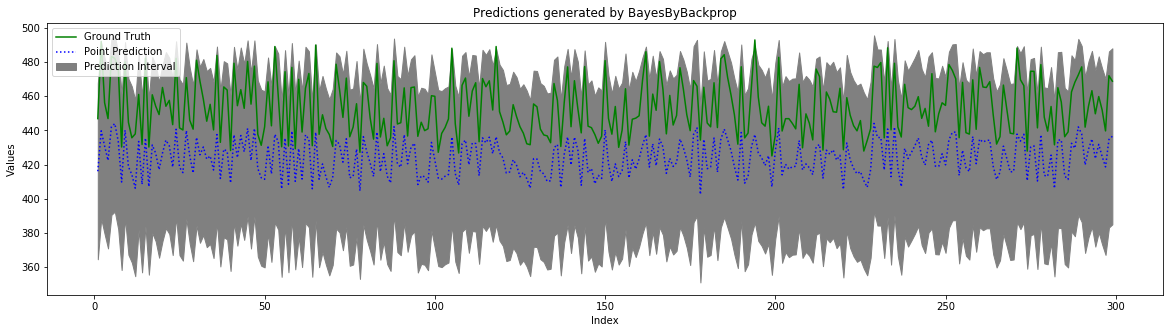

In [32]:
plot_prediction_intervals(results[1:300])